In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import ignite
from ignite.engine import create_supervised_evaluator

import backdoor_attack as bd
import backdoor_attack.plot_util
import net

torch.manual_seed(20200705) 

In [8]:
# result output folder
out = os.path.join('results', 'baseline_model')
os.makedirs(os.path.join(out), exist_ok=True)

# device setup
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=1)
else:
    device = torch.device(type='cpu')

## データセットの準備

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
ds_root = os.path.join('.', 'results', 'datasets')
tr = np.load(os.path.join(ds_root, 'clean_training_dataset.npz'))
train_ds = bd.Dataset_from_array(x=tr['x'], t=tr['t'], transform=transform)
te = np.load(os.path.join(ds_root, 'clean_test_dataset.npz'))
test_ds = bd.Dataset_from_array(x=te['x'], t=te['t'], transform=transform)
te_p = np.load(os.path.join(ds_root, 'poison_test_dataset.npz'))
test_p_ds = bd.Dataset_from_array(x=te_p['x'], t=te_p['t_correct'], transform=transform)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)
test_p_dl = torch.utils.data.DataLoader(test_p_ds, batch_size=128, shuffle=False)

## モデルの準備

In [11]:
model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 3, 32, 32)).astype(np.float32))
_ = model(dummy_input)

## 学習

In [12]:
trainer = bd.Trainer(train_dl, test_dl, model, device)
optimizer = torch.optim.Adam
epoch = 50

trainer.run(optimizer, epoch, out)

1/50 Epoch, Train/Test Loss: 1.1851/1.2367,         Train/Test Accuracy: 0.5551/0.5458,         Elapsed/Remaining time: 0.29/14.01 [min]
2/50 Epoch, Train/Test Loss: 0.3770/0.5975,         Train/Test Accuracy: 0.8738/0.8302,         Elapsed/Remaining time: 0.60/14.30 [min]
3/50 Epoch, Train/Test Loss: 0.1584/0.4357,         Train/Test Accuracy: 0.9454/0.8814,         Elapsed/Remaining time: 0.90/14.14 [min]
4/50 Epoch, Train/Test Loss: 0.1604/0.4313,         Train/Test Accuracy: 0.9481/0.8909,         Elapsed/Remaining time: 1.22/13.99 [min]
5/50 Epoch, Train/Test Loss: 0.1568/0.4313,         Train/Test Accuracy: 0.9603/0.9029,         Elapsed/Remaining time: 1.53/13.81 [min]
6/50 Epoch, Train/Test Loss: 0.0719/0.3758,         Train/Test Accuracy: 0.9818/0.9275,         Elapsed/Remaining time: 1.85/13.58 [min]
7/50 Epoch, Train/Test Loss: 0.1008/0.3643,         Train/Test Accuracy: 0.9725/0.9140,         Elapsed/Remaining time: 2.12/13.03 [min]
8/50 Epoch, Train/Test Loss: 0.0833/0.362

In [13]:
# Save result
torch.save(model.state_dict(), os.path.join(out, 'final_model.pt'))

np.savez(os.path.join(out, 'log.npz'), **trainer.log)

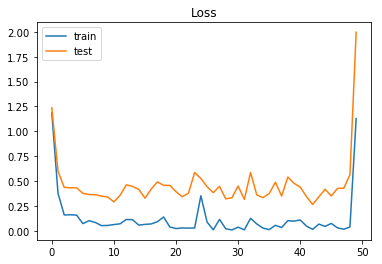

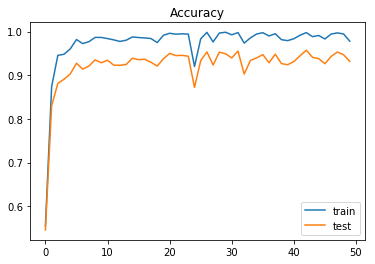

In [14]:
# Plot and save log figures
log = np.load(os.path.join(out, 'log.npz'))
bd.plot_util.plot_training_logs(log, out)

## 検証

In [15]:
val_model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 3, 32, 32)).astype(np.float32))
val_model(dummy_input)
val_model.load_state_dict(torch.load(os.path.join(out, 'best_model.pt')))
val_model = val_model.eval()

evaluator = bd.Evaluator(val_model, 43, device=device)

In [16]:
labels = np.load(os.path.join(ds_root, 'label_name.npz'))['label_name']

Accuracy: 0.9572446555819477


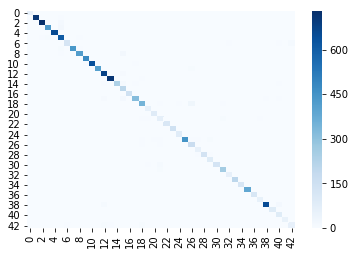

In [17]:
# Evaluation against clean dataset
ret = evaluator.run(
    test_dl,
    out=os.path.join(out, 'clean_test'),
    cmap='Blues',
    fmt='d',
    annot=False,
    cbar=True
)

Accuracy: 0.9522988505747126


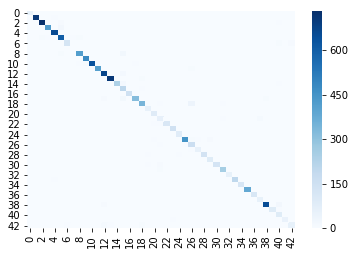

In [18]:
# Evaluation against poison dataset
ret = evaluator.run(
    test_p_dl,
    out=os.path.join(out, 'poison_test'),
    cmap='Blues',
    fmt='d',
    annot=False,
    cbar=True
)